# 🗺️ Blueprint Matcher - CORRECTED Testing Notebook

**✅ Compatible with MobileNetV2 Training Notebook**

This notebook:
- Loads the MobileNetV2 model (1280-dim embeddings)
- Uses the correct database structure (pairs)
- Applies proper preprocessing
- Returns single best match for each query

---

## Quick Start:
1. Run all cells in order
2. Upload your empty blueprint in Cell 7
3. Get the matched filled blueprint instantly!

In [1]:
# ============================================================================
# CELL 1: Mount Google Drive & Setup
# ============================================================================
print("📦 Setting up environment...\n")

from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)
print("✅ Google Drive mounted!\n")

# 🔴 MODIFY THIS: Path to your blueprint_embeddings_db folder
DB_FOLDER = '/content/drive/MyDrive/blueprint_embeddings_db'

# Verify folder exists
if os.path.exists(DB_FOLDER):
    print("✅ Found blueprint_embeddings_db folder\n")
    print("📁 Contents:")
    for item in sorted(os.listdir(DB_FOLDER)):
        item_path = os.path.join(DB_FOLDER, item)
        if os.path.isfile(item_path):
            size = os.path.getsize(item_path) / (1024*1024)  # MB
            print(f"   • {item:<30} ({size:.2f} MB)")
        else:
            print(f"   • {item:<30} [folder]")
else:
    raise FileNotFoundError(
        f"❌ Folder not found: {DB_FOLDER}\n"
        "Please update DB_FOLDER variable with correct path."
    )

📦 Setting up environment...

Mounted at /content/drive
✅ Google Drive mounted!

✅ Found blueprint_embeddings_db folder

📁 Contents:
   • database.pkl                   (11.21 MB)
   • faiss_index.bin                (5.54 MB)
   • feature_extractor.pth          (8.72 MB)
   • metadata.json                  (0.00 MB)
   • png_cache                      [folder]
   • sample_match_1.png             (0.15 MB)
   • sample_match_2.png             (0.15 MB)
   • sample_match_3.png             (0.15 MB)
   • sample_match_4.png             (0.14 MB)
   • sample_match_5.png             (0.14 MB)


In [2]:
# ============================================================================
# CELL 2: Install Dependencies
# ============================================================================
print("📦 Installing required packages...\n")

import subprocess
import sys

packages = ['faiss-cpu', 'pillow']

for package in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])

print("✅ All packages installed!")

📦 Installing required packages...

✅ All packages installed!


In [3]:
# ============================================================================
# CELL 3: Import Libraries
# ============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import faiss
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from google.colab import files

print("✅ Libraries imported")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"💻 Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

✅ Libraries imported
🔥 PyTorch version: 2.9.0+cu126
💻 Device: GPU
   GPU: Tesla T4


In [4]:
# ============================================================================
# CELL 4: Define Feature Extractor (Same as Training)
# ============================================================================
class BlueprintFeatureExtractor:
    """
    Extracts 1280-dimensional feature vectors from blueprints.
    Uses MobileNetV2 - MUST match training architecture!
    """
    def __init__(self, device='cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')

        # Load pretrained MobileNetV2 (same as training)
        print("📥 Loading MobileNetV2 (pretrained)...")
        mobilenet = models.mobilenet_v2(pretrained=True)

        # Remove classifier, keep only feature extractor
        self.model = mobilenet.features.eval().to(self.device)

        # Preprocessing pipeline (MUST match training)
        self.preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

        print(f"✅ Feature extractor ready on {self.device}")
        print(f"   Output dimension: 1280")

    @torch.no_grad()
    def extract_single(self, img_path):
        """Extract embedding from single image"""
        img = Image.open(img_path).convert('RGB')
        x = self.preprocess(img).unsqueeze(0).to(self.device)

        # Extract features
        features = self.model(x)

        # Global average pooling
        features = F.adaptive_avg_pool2d(features, (1, 1))

        # Flatten
        return features.cpu().numpy().flatten()

print("✅ Feature extractor class defined!")

✅ Feature extractor class defined!


In [9]:
# ============================================================================
# CELL 5: Load Database and FAISS Index
# ============================================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🔧 Using device: {device}\n")

# Load database
print("📂 Loading database...")
database_path = os.path.join(DB_FOLDER, 'database.pkl')
with open(database_path, 'rb') as f:
    database = pickle.load(f)

print(f"✅ Database loaded!")
print(f"   Total pairs: {database['num_pairs']}")
print(f"   Embeddings shape: {database['embeddings'].shape}")
print(f"   Created: {database['created_at']}")

# Load FAISS index
print("\n📂 Loading FAISS index...")
faiss_path = os.path.join(DB_FOLDER, 'faiss_index.bin')
index = faiss.read_index(faiss_path)
print(f"✅ FAISS index loaded!")
print(f"   Total vectors: {index.ntotal}")
print(f"   Dimension: {index.d}")

# Load metadata
print("\n📂 Loading metadata...")
metadata_path = os.path.join(DB_FOLDER, 'metadata.json')
with open(metadata_path, 'r') as f:
    metadata = json.load(f)
print(f"✅ Metadata loaded!")
print(f"   Config: {metadata}")


🔧 Using device: cuda

📂 Loading database...
✅ Database loaded!
   Total pairs: 1134
   Embeddings shape: (1134, 1280)
   Created: 2025-12-09 23:36:41

📂 Loading FAISS index...
✅ FAISS index loaded!
   Total vectors: 1134
   Dimension: 1280

📂 Loading metadata...
✅ Metadata loaded!
   Config: {'num_pairs': 1134, 'embedding_dim': 1280, 'img_size': 512, 'pdf_dpi': 300, 'created_at': '2025-12-09 23:36:41', 'min_similarity_threshold': 0.7, 'sample_pairs': [['/content/blueprint_embeddings_db/png_cache/empty/0000.png', '/content/blueprint_embeddings_db/png_cache/filled/0000.png'], ['/content/blueprint_embeddings_db/png_cache/empty/0001.png', '/content/blueprint_embeddings_db/png_cache/filled/0001.png'], ['/content/blueprint_embeddings_db/png_cache/empty/0002.png', '/content/blueprint_embeddings_db/png_cache/filled/0002.png'], ['/content/blueprint_embeddings_db/png_cache/empty/0003.png', '/content/blueprint_embeddings_db/png_cache/filled/0003.png'], ['/content/blueprint_embeddings_db/png_cach

In [10]:
# ============================================================================
# CELL 6: Initialize Blueprint Matcher
# ============================================================================
class BlueprintMatcher:
    """
    Fast blueprint matching system.
    Finds the SINGLE BEST filled blueprint for any empty input.
    """
    def __init__(self, database, index, device='cuda'):
        self.database = database
        self.index = index
        self.extractor = BlueprintFeatureExtractor(device=device)
        print(f"✅ Matcher initialized with {database['num_pairs']} blueprints")

    def find_best_match(self, input_image_path, threshold=0.70):
        """
        Find THE SINGLE BEST matching filled blueprint.

        Args:
            input_image_path: Path to empty blueprint PNG
            threshold: Minimum similarity (0-1)

        Returns:
            Dictionary with match info or None if no match above threshold
        """
        # Extract embedding
        query_embedding = self.extractor.extract_single(input_image_path)

        # Normalize for cosine similarity
        query_embedding = query_embedding.reshape(1, -1).astype('float32')
        faiss.normalize_L2(query_embedding)

        # Search for top 1 match
        similarities, indices = self.index.search(query_embedding, 1)

        best_idx = indices[0][0]
        best_score = float(similarities[0][0])

        # Check threshold
        if best_score < threshold:
            return None

        # Get the matched pair
        empty_path, filled_path = self.database['pairs'][best_idx]

        return {
            'index': int(best_idx),
            'similarity': float(best_score),
            'empty_path': empty_path,
            'filled_path': filled_path,
            'empty_name': Path(empty_path).name,
            'filled_name': Path(filled_path).name
        }

    def visualize_match(self, input_path, match_result):
        """Display side-by-side comparison"""
        if match_result is None:
            print("❌ No match found above threshold")
            return

        fig, axes = plt.subplots(1, 2, figsize=(14, 7))

        # Input image
        img_input = Image.open(input_path)
        axes[0].imshow(img_input)
        axes[0].set_title(
            f"Your Empty Blueprint\n{Path(input_path).name}",
            fontsize=14, fontweight='bold'
        )
        axes[0].axis('off')

        # Matched filled blueprint
        img_filled = Image.open(match_result['filled_path'])
        axes[1].imshow(img_filled)
        axes[1].set_title(
            f"Best Match (Filled)\n{match_result['filled_name']}\n"
            f"Similarity: {match_result['similarity']:.4f} ({match_result['similarity']*100:.1f}%)",
            fontsize=14, fontweight='bold', color='green'
        )
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

# Initialize matcher
print("\n🚀 Initializing blueprint matcher...\n")
matcher = BlueprintMatcher(database, index, device=device)
print("\n✅ Ready to match blueprints!")


🚀 Initializing blueprint matcher...

📥 Loading MobileNetV2 (pretrained)...
✅ Feature extractor ready on cuda
   Output dimension: 1280
✅ Matcher initialized with 1134 blueprints

✅ Ready to match blueprints!


In [8]:
# ============================================================================
# FIX: Copy database to expected location
# ============================================================================
import shutil
import os

SOURCE = '/content/drive/MyDrive/blueprint_embeddings_db'
DEST = '/content/blueprint_embeddings_db'

print(f"📂 Copying database from Google Drive to /content/...")
print(f"   From: {SOURCE}")
print(f"   To: {DEST}\n")

# Remove old folder if exists
if os.path.exists(DEST):
    shutil.rmtree(DEST)

# Copy entire folder
shutil.copytree(SOURCE, DEST)

print("✅ Database copied successfully!")
print("\nNow the paths in database.pkl will match the actual file locations.")
print("Re-run Cell 5 onwards to reload with correct paths.")

📂 Copying database from Google Drive to /content/...
   From: /content/drive/MyDrive/blueprint_embeddings_db
   To: /content/blueprint_embeddings_db

✅ Database copied successfully!

Now the paths in database.pkl will match the actual file locations.
Re-run Cell 5 onwards to reload with correct paths.


📤 UPLOAD YOUR EMPTY BLUEPRINT

Click 'Choose Files' below and select your empty blueprint PNG



Saving 60e.png to 60e (1).png

✅ Uploaded: 60e (1).png

🔍 SEARCHING FOR BEST MATCH...

✅ MATCH FOUND!

  📊 Similarity Score: 0.9384 (93.84%)
  📝 Database Index: 310
  📁 Filled Blueprint: 0310.png
  📍 Full Path: /content/blueprint_embeddings_db/png_cache/filled/0310.png
  🎯 Confidence: HIGH

📊 Displaying comparison...



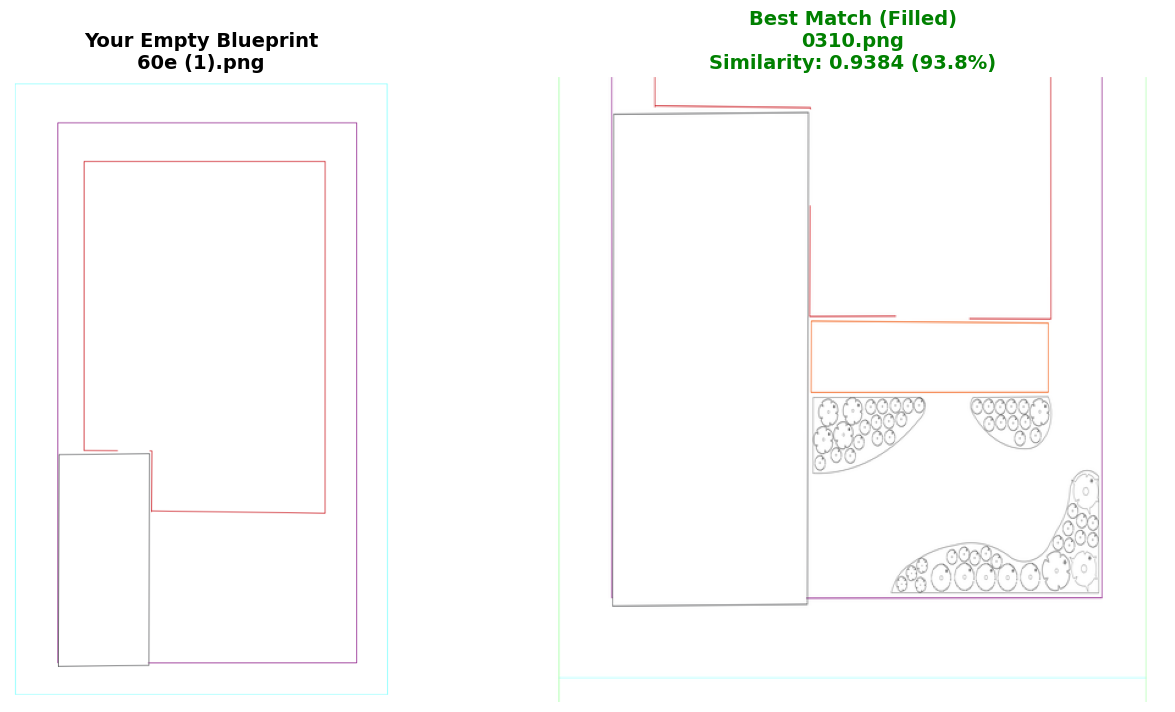


💾 Filled blueprint ready for YOLO detection:
   Path stored in variable: FILLED_BLUEPRINT_PATH
   /content/blueprint_embeddings_db/png_cache/filled/0310.png



In [11]:
# ============================================================================
# CELL 7: Upload and Test Your Blueprint
# ============================================================================
print("="*80)
print("📤 UPLOAD YOUR EMPTY BLUEPRINT")
print("="*80)
print("\nClick 'Choose Files' below and select your empty blueprint PNG\n")

uploaded = files.upload()

if uploaded:
    # Get uploaded file
    uploaded_filename = list(uploaded.keys())[0]
    print(f"\n✅ Uploaded: {uploaded_filename}")

    # Find best match
    print("\n" + "="*80)
    print("🔍 SEARCHING FOR BEST MATCH...")
    print("="*80)

    match = matcher.find_best_match(
        uploaded_filename,
        threshold=0.70  # 70% similarity threshold
    )

    # Display results
    if match:
        print("\n" + "="*80)
        print("✅ MATCH FOUND!")
        print("="*80)
        print(f"\n  📊 Similarity Score: {match['similarity']:.4f} ({match['similarity']*100:.2f}%)")
        print(f"  📝 Database Index: {match['index']}")
        print(f"  📁 Filled Blueprint: {match['filled_name']}")
        print(f"  📍 Full Path: {match['filled_path']}")

        confidence = 'HIGH' if match['similarity'] > 0.85 else 'MEDIUM' if match['similarity'] > 0.75 else 'LOW'
        print(f"  🎯 Confidence: {confidence}")

        # Visualize
        print("\n📊 Displaying comparison...\n")
        matcher.visualize_match(uploaded_filename, match)

        # Save filled path for YOLO integration
        FILLED_BLUEPRINT_PATH = match['filled_path']
        print(f"\n💾 Filled blueprint ready for YOLO detection:")
        print(f"   Path stored in variable: FILLED_BLUEPRINT_PATH")
        print(f"   {FILLED_BLUEPRINT_PATH}")

    else:
        print("\n" + "="*80)
        print("❌ NO MATCH FOUND")
        print("="*80)
        print(f"\nNo blueprint found with similarity >= 70%")
        print("\nOptions:")
        print("  1. Try lowering threshold in Cell 8")
        print("  2. Check if your blueprint matches the dataset style")
        print("  3. Verify image quality and format")

print("\n" + "="*80)

In [ ]:
# ============================================================================
# CELL 8: Adjust Threshold (Optional)
# ============================================================================
# If no match was found, try with a lower threshold:

def test_with_threshold(threshold=0.50):
    """Test with custom threshold"""
    if 'uploaded_filename' not in globals():
        print("⚠️ Please upload an image first (run Cell 7)")
        return

    print(f"\n🔍 Searching with {threshold*100:.0f}% threshold...\n")
    match = matcher.find_best_match(uploaded_filename, threshold=threshold)

    if match:
        print(f"✅ Match found! Similarity: {match['similarity']*100:.2f}%")
        matcher.visualize_match(uploaded_filename, match)
        return match
    else:
        print(f"❌ Still no match found above {threshold*100:.0f}% threshold")
        return None

# Uncomment and run to test with different thresholds:
# test_with_threshold(0.60)  # 60%
# test_with_threshold(0.50)  # 50%
# test_with_threshold(0.40)  # 40%

print("\n💡 Tip: Lower thresholds are more lenient but may give false matches.")
print("   Recommended: 0.70-0.85 for production use")

In [ ]:
# ============================================================================
# CELL 9: Batch Testing (Optional)
# ============================================================================
def batch_test_blueprints(folder_path, threshold=0.70):
    """
    Test multiple blueprints from a folder.
    Returns SINGLE BEST match for each blueprint.
    """
    if not os.path.exists(folder_path):
        print(f"❌ Folder not found: {folder_path}")
        return {}

    # Find all image files
    image_files = []
    for ext in ['*.png', '*.jpg', '*.jpeg']:
        image_files.extend(Path(folder_path).glob(ext))

    print(f"Found {len(image_files)} images in folder\n")
    print("="*80)

    results = {}
    success_count = 0

    for img_path in image_files:
        match = matcher.find_best_match(str(img_path), threshold=threshold)
        results[img_path.name] = match

        if match:
            success_count += 1
            print(f"✅ {img_path.name:<30} → {match['similarity']*100:>6.2f}% match")
        else:
            print(f"❌ {img_path.name:<30} → No match")

    print("="*80)
    print(f"\nResults: {success_count}/{len(image_files)} matched ({success_count/len(image_files)*100:.1f}%)")

    return results

# Example usage:
# results = batch_test_blueprints('/content/drive/MyDrive/test_blueprints/', threshold=0.70)

print("✅ Batch testing function ready!")
print("\nUsage: batch_test_blueprints('/path/to/folder/', threshold=0.70)")

In [ ]:
# ============================================================================
# CELL 10: Summary & Next Steps
# ============================================================================
print("\n" + "="*80)
print("🎉 BLUEPRINT MATCHER TESTING NOTEBOOK")
print("="*80)
print("\n✅ Status: READY")
print(f"✅ Database: {database['num_pairs']} blueprint pairs loaded")
print(f"✅ Model: MobileNetV2 (1280-dim embeddings)")
print(f"✅ Search: FAISS index with {index.ntotal} vectors")

print("\n" + "="*80)
print("📋 HOW TO USE:")
print("="*80)
print("\n1️⃣  Upload empty blueprint (Cell 7)")
print("2️⃣  View THE SINGLE BEST filled match")
print("3️⃣  Adjust threshold if needed (Cell 8)")
print("4️⃣  Batch test multiple files (Cell 9)")

print("\n" + "="*80)
print("🔗 NEXT STEPS FOR WEB APP INTEGRATION:")
print("="*80)
print("\n1. Use matched FILLED_BLUEPRINT_PATH with YOLO model")
print("2. Run symbol detection: model.predict(FILLED_BLUEPRINT_PATH)")
print("3. Return detection results to frontend")

print("\n" + "="*80)
print("⚙️ RECOMMENDED SETTINGS:")
print("="*80)
print("\n• Threshold: 0.70-0.85 (production)")
print("• Threshold: 0.50-0.70 (testing/development)")
print("• Returns: Single best match only")
print("• Speed: ~0.1-0.2 seconds per query")

print("\n" + "="*80)

In [ ]:
# ============================================================================
# CELL 11: Install Ultralytics YOLO
# ============================================================================
print("📦 Installing Ultralytics YOLO...\n")
import subprocess
import sys

subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'ultralytics'])

print("✅ Ultralytics YOLO installed!")

In [13]:
# ============================================================================
# CELL 12: Load YOLO Model
# ============================================================================
!pip install ultralytics
from ultralytics import YOLO
import cv2

print("="*80)
print("🤖 LOADING YOLO MODEL")
print("="*80)

# 🔴 MODIFY THIS: Path to your YOLO model in Google Drive
YOLO_MODEL_PATH = '/content/drive/MyDrive/Florify_Training/training_runs/session_4/weights/best.pt'

# Verify model exists
if not os.path.exists(YOLO_MODEL_PATH):
    raise FileNotFoundError(
        f"❌ YOLO model not found: {YOLO_MODEL_PATH}\n"
        f"Please check the path and update YOLO_MODEL_PATH variable."
    )

print(f"\n📂 Loading YOLO model from:")
print(f"   {YOLO_MODEL_PATH}\n")

# Load YOLO model
yolo_model = YOLO(YOLO_MODEL_PATH)

print("✅ YOLO model loaded successfully!")
print(f"\n📊 Model Info:")
print(f"   Task: {yolo_model.task}")

# Get class names
if hasattr(yolo_model, 'names'):
    print(f"\n🏷️  Detected Classes ({len(yolo_model.names)}):")
    for idx, name in yolo_model.names.items():
        print(f"   {idx}: {name}")

print("\n" + "="*80)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🤖 LOADING YOLO MODEL

📂 Loading YOLO model from:
   /content/drive/MyDrive/Florify_Training/training_runs/session_4/weights/best.pt

✅ YOLO model loaded successfully!

📊 Model Info:
   Task: detect

🏷️  Detected Classes (299):
   0: Annual_Height1_CanopySize1_Flowering
   1: Annual_Height1_CanopySize1_NONFlowering
   2: Annual_Height1_CanopySize2_Flowering
   3: Annual_Height1_CanopySize2_NONFlowering
   4: Annuals_CanopySize1_NONFlowering
   5: Climber_Horizontal_Size1
   6: FlowerPot
   7: Perennials_Height1_CanopySize1_Deciduous_BroadLeafed_Fruiting
   8: Rock_DecendingSize1
   9: Rock_DecendingSize2
 

In [14]:
# ============================================================================
# CELL 13: Run YOLO Detection on Matched Blueprint
# ============================================================================
print("="*80)
print("🎯 YOLO DETECTION ON MATCHED BLUEPRINT")
print("="*80)

if 'match' not in globals() or match is None:
    print("\n❌ No match found yet!")
    print("Please run Cell 7 first to upload and match a blueprint.")
else:
    print(f"\n📋 Running YOLO detection on matched filled blueprint...")
    print(f"   Blueprint: {match['filled_name']}")
    print(f"   Path: {match['filled_path']}\n")

    # Verify file exists
    if not os.path.exists(match['filled_path']):
        print(f"⚠️  File not found at stored path, trying to fix...")
        filename = Path(match['filled_path']).name
        match['filled_path'] = os.path.join(DB_FOLDER, 'png_cache/filled', filename)
        print(f"   Using: {match['filled_path']}")

    if os.path.exists(match['filled_path']):
        # Run YOLO detection
        print("🔍 Running detection...\n")

        results = yolo_model.predict(
            source=match['filled_path'],
            conf=0.25,  # Confidence threshold
            iou=0.45,   # IoU threshold for NMS
            save=False,
            verbose=False
        )

        result = results[0]
        num_detections = len(result.boxes)

        print("="*80)
        print("✅ DETECTION COMPLETE!")
        print("="*80)
        print(f"\n📊 Found {num_detections} objects\n")

        if num_detections > 0:
            print("🔍 Detection Details:")
            print("-"*80)

            for i, box in enumerate(result.boxes):
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                conf = box.conf[0].cpu().numpy()
                cls = int(box.cls[0].cpu().numpy())
                class_name = yolo_model.names[cls]

                print(f"\n  Detection {i+1}:")
                print(f"    • Class: {class_name}")
                print(f"    • Confidence: {conf:.2%}")
                print(f"    • Box: ({x1:.1f}, {y1:.1f}) → ({x2:.1f}, {y2:.1f})")

            print("\n" + "-"*80)

            # Class distribution
            class_counts = {}
            for box in result.boxes:
                cls = int(box.cls[0].cpu().numpy())
                class_name = yolo_model.names[cls]
                class_counts[class_name] = class_counts.get(class_name, 0) + 1

            print("\n📈 Detection Summary:")
            for class_name, count in sorted(class_counts.items()):
                print(f"   • {class_name}: {count}")
        else:
            print("⚠️  No objects detected above confidence threshold")

        print("\n" + "="*80)
    else:
        print(f"❌ File not found: {match['filled_path']}")

🎯 YOLO DETECTION ON MATCHED BLUEPRINT

📋 Running YOLO detection on matched filled blueprint...
   Blueprint: 0310.png
   Path: /content/blueprint_embeddings_db/png_cache/filled/0310.png

🔍 Running detection...

✅ DETECTION COMPLETE!

📊 Found 35 objects

🔍 Detection Details:
--------------------------------------------------------------------------------

  Detection 1:
    • Class: Shrub_Height2_CanopySize1_Evergreen_Flowering_NONFruiting
    • Confidence: 89.38%
    • Box: (433.9, 321.0) → (461.7, 360.1)

  Detection 2:
    • Class: perennials_Height2_CanopySize2_Evergreen_BroadLeafed_Flowering
    • Confidence: 82.91%
    • Box: (298.1, 399.0) → (310.8, 414.6)

  Detection 3:
    • Class: perennials_Height2_CanopySize2_Evergreen_BroadLeafed_Flowering
    • Confidence: 82.62%
    • Box: (305.7, 407.9) → (318.0, 423.5)

  Detection 4:
    • Class: perennials_Height2_CanopySize2_Evergreen_BroadLeafed_Flowering
    • Confidence: 82.34%
    • Box: (289.4, 407.6) → (302.4, 423.6)

  Detect

📊 VISUALIZING COMPLETE PIPELINE


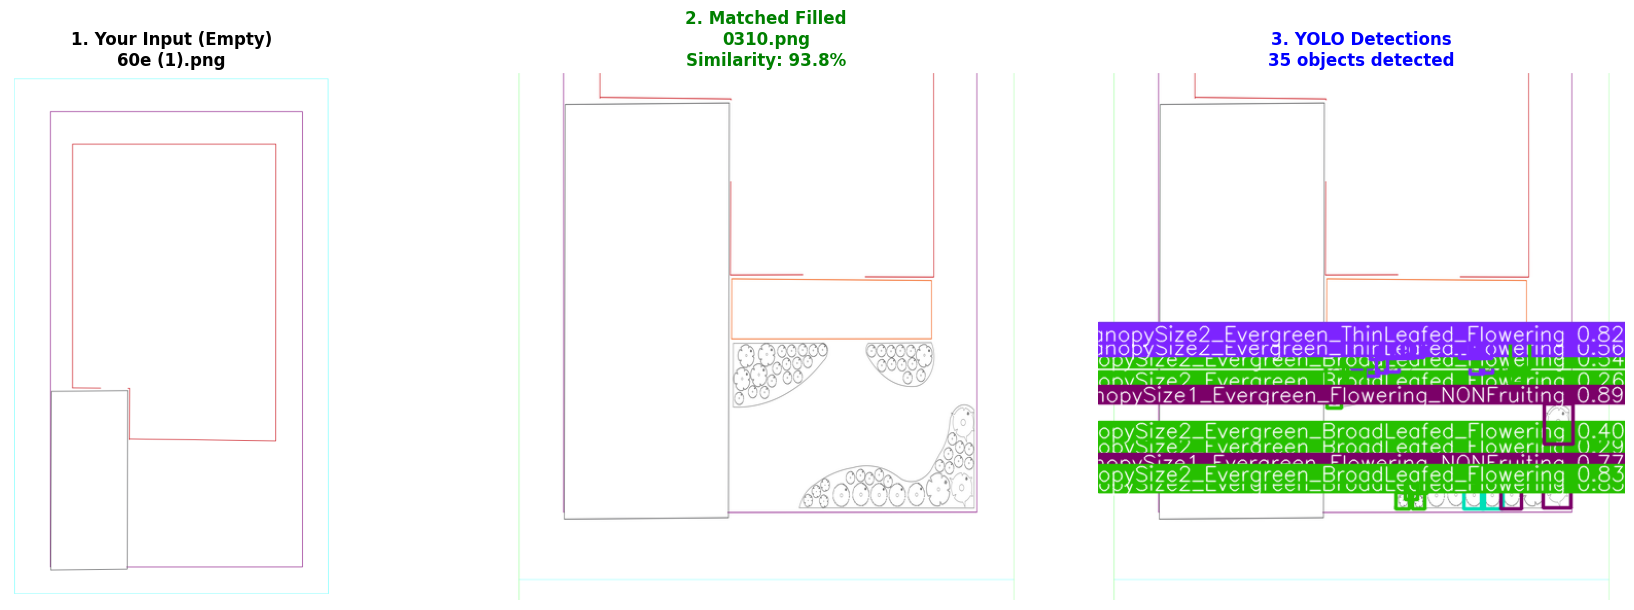


✅ Complete pipeline visualization displayed!

📋 Pipeline: Empty → Match → Detect


In [15]:
# ============================================================================
# CELL 14: Visualize YOLO Detections
# ============================================================================
print("="*80)
print("📊 VISUALIZING COMPLETE PIPELINE")
print("="*80)

if 'results' not in globals():
    print("\n❌ No detection results available!")
    print("Please run Cell 13 first.")
else:
    # Get annotated image
    annotated_img = results[0].plot()  # BGR format
    annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

    # Create 3-panel visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Panel 1: Original empty blueprint
    if 'uploaded_filename' in globals():
        img_empty = Image.open(uploaded_filename)
        axes[0].imshow(img_empty)
        axes[0].set_title(
            f"1. Your Input (Empty)\n{Path(uploaded_filename).name}",
            fontsize=12, fontweight='bold'
        )
    else:
        axes[0].text(0.5, 0.5, 'Input\nNot Available',
                    ha='center', va='center', fontsize=12)
        axes[0].set_title("1. Your Input", fontsize=12)
    axes[0].axis('off')

    # Panel 2: Matched filled blueprint (clean)
    img_filled = Image.open(match['filled_path'])
    axes[1].imshow(img_filled)
    axes[1].set_title(
        f"2. Matched Filled\n{match['filled_name']}\nSimilarity: {match['similarity']*100:.1f}%",
        fontsize=12, fontweight='bold', color='green'
    )
    axes[1].axis('off')

    # Panel 3: YOLO detections
    axes[2].imshow(annotated_img_rgb)
    num_det = len(results[0].boxes)
    axes[2].set_title(
        f"3. YOLO Detections\n{num_det} objects detected",
        fontsize=12, fontweight='bold', color='blue'
    )
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    print("\n✅ Complete pipeline visualization displayed!")
    print("\n📋 Pipeline: Empty → Match → Detect")

In [16]:
# ============================================================================
# CELL 15: Save Detection Results
# ============================================================================
import shutil

print("="*80)
print("💾 SAVING DETECTION RESULTS")
print("="*80)

if 'results' not in globals():
    print("\n❌ No detection results available!")
    print("Please run Cell 13 first.")
else:
    # Create output directory
    output_dir = '/content/yolo_detections'
    os.makedirs(output_dir, exist_ok=True)

    base_name = Path(match['filled_name']).stem

    # 1. Save annotated image
    annotated_path = os.path.join(output_dir, f"{base_name}_detected.png")
    cv2.imwrite(annotated_path, results[0].plot())
    print(f"\n✅ Annotated image saved:")
    print(f"   {annotated_path}")

    # 2. Save detection data as JSON
    detections_data = {
        'input_blueprint': uploaded_filename if 'uploaded_filename' in globals() else 'N/A',
        'matched_blueprint': match['filled_name'],
        'similarity_score': float(match['similarity']),
        'num_detections': len(results[0].boxes),
        'detections': []
    }

    for i, box in enumerate(results[0].boxes):
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        conf = float(box.conf[0].cpu().numpy())
        cls = int(box.cls[0].cpu().numpy())
        class_name = yolo_model.names[cls]

        detections_data['detections'].append({
            'id': i + 1,
            'class': class_name,
            'class_id': cls,
            'confidence': conf,
            'bbox': {
                'x1': float(x1), 'y1': float(y1),
                'x2': float(x2), 'y2': float(y2),
                'width': float(x2 - x1),
                'height': float(y2 - y1)
            }
        })

    json_path = os.path.join(output_dir, f"{base_name}_detections.json")
    with open(json_path, 'w') as f:
        json.dump(detections_data, f, indent=2)

    print(f"\n✅ Detection data (JSON):")
    print(f"   {json_path}")

    # 3. Save original filled blueprint
    original_path = os.path.join(output_dir, f"{base_name}_filled_original.png")
    shutil.copy(match['filled_path'], original_path)
    print(f"\n✅ Original filled blueprint:")
    print(f"   {original_path}")

    print("\n" + "="*80)
    print(f"📁 All files saved to: {output_dir}")
    print("="*80)

    # List files
    print("\n📄 Files created:")
    for file in sorted(os.listdir(output_dir)):
        file_path = os.path.join(output_dir, file)
        size = os.path.getsize(file_path) / 1024  # KB
        print(f"   • {file} ({size:.1f} KB)")

    # Store path for web app use
    DETECTION_RESULTS_PATH = json_path
    ANNOTATED_IMAGE_PATH = annotated_path

    print("\n🔗 For web app integration:")
    print(f"   Detection JSON: DETECTION_RESULTS_PATH")
    print(f"   Annotated Image: ANNOTATED_IMAGE_PATH")

💾 SAVING DETECTION RESULTS

✅ Annotated image saved:
   /content/yolo_detections/0310_detected.png

✅ Detection data (JSON):
   /content/yolo_detections/0310_detections.json

✅ Original filled blueprint:
   /content/yolo_detections/0310_filled_original.png

📁 All files saved to: /content/yolo_detections

📄 Files created:
   • 0310_detected.png (131.5 KB)
   • 0310_detections.json (13.8 KB)
   • 0310_filled_original.png (35.4 KB)

🔗 For web app integration:
   Detection JSON: DETECTION_RESULTS_PATH
   Annotated Image: ANNOTATED_IMAGE_PATH
